*Accompanying code examples of the book "Introduction to Artificial Neural Networks and Deep Learning: A Practical Guide with Applications in Python" by [Sebastian Raschka](https://sebastianraschka.com). All code examples are released under the [MIT license](https://github.com/rasbt/deep-learning-book/blob/master/LICENSE). If you find this content useful, please consider supporting the work by buying a [copy of the book](https://leanpub.com/ann-and-deeplearning).*
  
Other code examples and content are available on [GitHub](https://github.com/rasbt/deep-learning-book). The PDF and ebook versions of the book are available through [Leanpub](https://leanpub.com/ann-and-deeplearning).

In [2]:
#load watermark
%load_ext watermark
%watermark -a 'Gopala KR' -u -d -v -p watermark,numpy,matplotlib,nltk,sklearn,tensorflow,theano,mxnet,chainer,seaborn,keras,tflearn,bokeh,gensim

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


/srv/venv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Using TensorFlow backend.
/srv/venv/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))


Gopala KR 
last updated: 2018-02-28 

CPython 3.6.3
IPython 6.2.1

watermark 1.6.0
numpy 1.14.1
matplotlib 2.1.2
nltk 3.2.5
sklearn 0.19.1
tensorflow 1.5.0
theano 1.0.1
mxnet 1.1.0
chainer 3.4.0
seaborn 0.8.1
keras 2.1.4
tflearn n
bokeh 0.12.14
gensim 3.3.0


/srv/venv/lib/python3.6/site-packages/scipy/sparse/sparsetools.py:20: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


# Using Input Pipelines to Read Data from TFRecords Files

TensorFlow provides users with multiple options for providing data to the model. One of the probably most common methods is to define placeholders in the TensorFlow graph and feed the data from the current Python session into the TensorFlow `Session` using the `feed_dict` parameter. Using this approach, a large dataset that does not fit into memory is most conveniently and efficiently stored using NumPy archives as explained in [Chunking an Image Dataset for Minibatch Training using NumPy NPZ Archives](image-data-chunking-npz.ipynb) or HDF5 data base files ([Storing an Image Dataset for Minibatch Training using HDF5](image-data-chunking-hdf5.ipynb)).

Another approach, which is often preferred when it comes to computational efficiency, is to do the "data loading" directly in the graph using input queues from so-called TFRecords files, which will be illustrated in this notebook.

Beyond the examples in this notebook, you are encouraged to read more in TensorFlow's "[Reading Data](https://www.tensorflow.org/programmers_guide/reading_data)" guide.

## 0. The Dataset

Let's pretend we have a directory of images containing two subdirectories with images for training, validation, and testing. The following function will create such a dataset of images in JPEG format locally for demonstration purposes.

In [3]:
# Note that executing the following code 
# cell will download the MNIST dataset
# and save all the 60,000 images as separate JPEG
# files. This might take a few minutes depending
# on your machine.

import numpy as np
from helper import mnist_export_to_jpg

np.random.seed(123)
mnist_export_to_jpg(path='./')

Extracting ./train-images-idx3-ubyte.gz
Extracting ./train-labels-idx1-ubyte.gz
Extracting ./t10k-images-idx3-ubyte.gz
Extracting ./t10k-labels-idx1-ubyte.gz


The `mnist_export_to_jpg` function called above creates 3 directories, mnist_train, mnist_test, and mnist_validation. Note that the names of the subdirectories correspond directly to the class label of the images that are stored under it:

In [4]:
import os

for i in ('train', 'valid', 'test'): 
    dirs = [d for d in os.listdir('mnist_%s' % i) if not d.startswith('.')]
    print('mnist_%s subdirectories' % i, dirs)

mnist_train subdirectories ['6', '5', '2', '1', '7', '8', '4', '9', '3', '0']
mnist_valid subdirectories ['6', '5', '2', '1', '7', '8', '4', '9', '3', '0']
mnist_test subdirectories ['6', '5', '2', '1', '7', '8', '4', '9', '3', '0']


To make sure that the images look okay, the snippet below plots an example image from the subdirectory `mnist_train/9/`:

(28, 28)


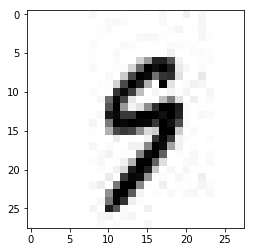

In [5]:
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os

some_img = os.path.join('./mnist_train/9/', os.listdir('./mnist_train/9/')[0])

img = mpimg.imread(some_img)
print(img.shape)
plt.imshow(img, cmap='binary');

Note: The JPEG format introduces a few artifacts that we can see in the image above. In this case, we use JPEG instead of PNG. Here, JPEG is used for demonstration purposes since that's still format many image datasets are stored in.

## 1. Saving images as TFRecords files

First, we are going to convert the images into a binary TFRecords file, which is based on Google's [protocol buffer](https://developers.google.com/protocol-buffers/) format:

> The recommended format for TensorFlow is a TFRecords file containing tf.train.Example protocol buffers (which contain Features as a field). You write a little program that gets your data, stuffs it in an Example protocol buffer, serializes the protocol buffer to a string, and then writes the string to a TFRecords file using the tf.python_io.TFRecordWriter. For example, tensorflow/examples/how_tos/reading_data/convert_to_records.py converts MNIST data to this format.  

> [ Excerpt from https://www.tensorflow.org/programmers_guide/reading_data ]



In [6]:
import glob
import numpy as np
import tensorflow as tf


def images_to_tfrecords(data_stempath='./mnist_',
                        shuffle=False, 
                        random_seed=None):
    
    def int64_to_feature(value):
        return tf.train.Feature(int64_list=tf.train.Int64List(value=value))
    
    for s in ['train', 'valid', 'test']:

        with tf.python_io.TFRecordWriter('mnist_%s.tfrecords' % s) as writer:

            img_paths = np.array([p for p in glob.iglob('%s%s/**/*.jpg' % 
                                  (data_stempath, s), 
                                   recursive=True)])

            if shuffle:
                rng = np.random.RandomState(random_seed)
                rng.shuffle(img_paths)

            for idx, path in enumerate(img_paths):
                label = int(os.path.basename(os.path.dirname(path)))
                image = mpimg.imread(path)
                image = image.reshape(-1).tolist()


                example = tf.train.Example(features=tf.train.Features(feature={
                    'image': int64_to_feature(image),
                    'label': int64_to_feature([label])}))

                writer.write(example.SerializeToString())

Note that it is important to shuffle the dataset so that we can later make use of TensorFlow's [`tf.train.shuffle_batch`](https://www.tensorflow.org/api_docs/python/tf/train/shuffle_batch) function and don't need to load the whole dataset into memory to shuffle epochs.

In [7]:
images_to_tfrecords(shuffle=True, random_seed=123)

Just to make sure that the images were serialized correctly, let us load an image back from TFRecords using the [`tf.python_io.tf_record_iterator`](https://www.tensorflow.org/api_docs/python/tf/python_io/tf_record_iterator) and display it:

Label: 2


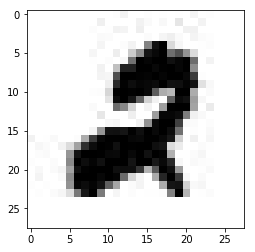

In [8]:
import tensorflow as tf
import numpy as np


record_iterator = tf.python_io.tf_record_iterator(path='mnist_train.tfrecords')

for r in record_iterator:
    example = tf.train.Example()
    example.ParseFromString(r)
    
    label = example.features.feature['label'].int64_list.value[0]
    print('Label:', label)
    img = np.array(example.features.feature['image'].int64_list.value)
    img = img.reshape((28, 28))
    plt.imshow(img, cmap='binary')
    plt.show
    break

So far so good, the image above looks okay. In the next secction, we will introduce a slightly different approach for loading the images, namely, the [`TFRecordReader`](https://www.tensorflow.org/api_docs/python/tf/TFRecordReader), which we need to load images inside a TensorFlow graph.

## 2. Loading images via the TFRecordReader

Roughly speaking, we can regard the [`TFRecordReader`](https://www.tensorflow.org/api_docs/python/tf/TFRecordReader) as a class that let's us load images "symbolically" inside a TensorFlow graph. A `TFRecordReader`  uses the state in the graph to remember the location of a `.tfrecord` file that it reads and lets us iterate over training examples and batches after initializing the graph as we will see later.

To see how it works, let's start with a simple function that reads one image at a time:

In [9]:
def read_one_image(tfrecords_queue, normalize=True):

    reader = tf.TFRecordReader()
    key, value = reader.read(tfrecords_queue)
    features = tf.parse_single_example(value,
        features={'label': tf.FixedLenFeature([], tf.int64),
                  'image': tf.FixedLenFeature([784], tf.int64)})
    label = tf.cast(features['label'], tf.int32)
    image = tf.cast(features['image'], tf.float32)
    onehot_label = tf.one_hot(indices=label, depth=10)
    
    if normalize:
        # normalize to [0, 1] range
        image = image / 255.
    
    return onehot_label, image

To use this `read_one_image` function to fetch images in a TensorFlow session, we will make use of queue runners as illustrated in the following example:

In [10]:
g = tf.Graph()
with g.as_default():
    
    queue = tf.train.string_input_producer(['mnist_train.tfrecords'], 
                                           num_epochs=10)
    label, image = read_one_image(queue)


with tf.Session(graph=g) as sess:
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
   
    for i in range(10):
        one_label, one_image = sess.run([label, image])
        
    print('Label:', one_label, '\nImage dimensions:', one_image.shape)
    
    coord.request_stop()
    coord.join(threads)

Label: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.] 
Image dimensions: (784,)


- The `tf.train.string_input_producer` produces a filename queue that we iterate over in the session. Note that we need to call `sess.run(tf.local_variables_initializer())` if we define a fixed number of `num_epochs` in `tf.train.string_input_producer`. Alternatively, `num_epochs` can be set to `None` to iterate "infinitely." 

- The `tf.train.start_queue_runners` function uses a queue runner that uses a separate thread to load the filenames from the `queue` that we defined in the graph without blocking the reader.

However, we rarely (want to) train neural networks with one datapoint at a time but use minibatches instead. TensorFlow also has some really convenient utility functions to do the batching conveniently. In the following code example, we will use the [`tf.train.shuffle_batch`](https://www.tensorflow.org/api_docs/python/tf/train/shuffle_batch) function to load the images and labels in batches of size 64:

In [11]:
g = tf.Graph()
with g.as_default():
    
    queue = tf.train.string_input_producer(['mnist_train.tfrecords'], 
                                           num_epochs=10)
    label, image = read_one_image(queue)
    
    
    label_batch, image_batch = tf.train.shuffle_batch([label, image], 
                                                       batch_size=64,
                                                       capacity=5000,
                                                       min_after_dequeue=2000,
                                                       num_threads=8,
                                                       seed=123)

with tf.Session(graph=g) as sess:
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
   
    for i in range(10):
        many_labels, many_images = sess.run([label_batch, image_batch])
        
    print('Batch size:', many_labels.shape[0])
    
    coord.request_stop()
    coord.join(threads)

Batch size: 64


The other relevant arguments we provided to `tf.train.shuffle_batch` are described below:

- `capacity`: An integer that defines the maximum number of elements in the queue.
- `min_after_dequeue`: The minimum number elements in the queue after a dequeue, which is used to ensure that a minimum number of data points have been loaded for shuffling.
- `num_threads`: The number of threads for enqueuing.


## 3. Use queue runners to train a neural network

In this section, we will take the concepts that were introduced in the previous sections and train a multilayer perceptron from the `'mnist_train.tfrecords'` file:
                                  

In [12]:
##########################
### SETTINGS
##########################

# Hyperparameters
learning_rate = 0.1
batch_size = 128
n_epochs = 15
n_iter = n_epochs * (45000 // batch_size)

# Architecture
n_hidden_1 = 128
n_hidden_2 = 256
height, width = 28, 28
n_classes = 10



##########################
### GRAPH DEFINITION
##########################

g = tf.Graph()
with g.as_default():
    
    tf.set_random_seed(123)

    # Input data
    queue = tf.train.string_input_producer(['mnist_train.tfrecords'], 
                                           num_epochs=None)
    label, image = read_one_image(queue)
    
    label_batch, image_batch = tf.train.shuffle_batch([label, image], 
                                                       batch_size=batch_size,
                                                       seed=123,
                                                       num_threads=8,
                                                       capacity=5000,
                                                       min_after_dequeue=2000)
    
    tf_images = tf.placeholder_with_default(image_batch,
                                            shape=[None, 784], 
                                            name='images')
    tf_labels = tf.placeholder_with_default(label_batch, 
                                            shape=[None, 10], 
                                            name='labels')

    # Model parameters
    weights = {
        'h1': tf.Variable(tf.truncated_normal([height*width, n_hidden_1], stddev=0.1)),
        'h2': tf.Variable(tf.truncated_normal([n_hidden_1, n_hidden_2], stddev=0.1)),
        'out': tf.Variable(tf.truncated_normal([n_hidden_2, n_classes], stddev=0.1))
    }
    biases = {
        'b1': tf.Variable(tf.zeros([n_hidden_1])),
        'b2': tf.Variable(tf.zeros([n_hidden_2])),
        'out': tf.Variable(tf.zeros([n_classes]))
    }

    # Multilayer perceptron
    layer_1 = tf.add(tf.matmul(tf_images, weights['h1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out']

    # Loss and optimizer
    loss = tf.nn.softmax_cross_entropy_with_logits(logits=out_layer, labels=tf_labels)
    cost = tf.reduce_mean(loss, name='cost')
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    train = optimizer.minimize(cost, name='train')

    # Prediction
    prediction = tf.argmax(out_layer, 1, name='prediction')
    correct_prediction = tf.equal(tf.argmax(label_batch, 1), tf.argmax(out_layer, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='accuracy')
    
    
    
with tf.Session(graph=g) as sess:
    sess.run(tf.global_variables_initializer())
    saver0 = tf.train.Saver()
    
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    
    avg_cost = 0.
    iter_per_epoch = n_iter // n_epochs
    epoch = 0

    for i in range(n_iter):
        _, cost = sess.run(['train', 'cost:0'])
        avg_cost += cost
        
        if not i % iter_per_epoch:
            epoch += 1
            avg_cost /= iter_per_epoch
            print("Epoch: %03d | AvgCost: %.3f" % (epoch, avg_cost))
            avg_cost = 0.
            
        
    coord.request_stop()
    coord.join(threads)
    
    saver0.save(sess, save_path='./mlp')

/srv/venv/lib/python3.6/site-packages/tensorflow/python/framework/tensor_util.py:539: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)


Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



/srv/venv/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))


Epoch: 001 | AvgCost: 0.007
Epoch: 002 | AvgCost: 0.469
Epoch: 003 | AvgCost: 0.239
Epoch: 004 | AvgCost: 0.184
Epoch: 005 | AvgCost: 0.150
Epoch: 006 | AvgCost: 0.127
Epoch: 007 | AvgCost: 0.110
Epoch: 008 | AvgCost: 0.098
Epoch: 009 | AvgCost: 0.087
Epoch: 010 | AvgCost: 0.078
Epoch: 011 | AvgCost: 0.069
Epoch: 012 | AvgCost: 0.064
Epoch: 013 | AvgCost: 0.057
Epoch: 014 | AvgCost: 0.052
Epoch: 015 | AvgCost: 0.047


After looking at the graph above, you probably wondered why we used [`tf.placeholder_with_default`](https://www.tensorflow.org/api_docs/python/tf/placeholder_with_default) to define the two placeholders:

```python
tf_images = tf.placeholder_with_default(image_batch,
                                            shape=[None, 784], 
                                            name='images')
tf_labels = tf.placeholder_with_default(label_batch, 
                                        shape=[None, 10], 
                                        name='labels')
```      

In the training session above, these placeholders are being ignored if we don't feed them via a session's `feed_dict`, or in other words "[A `tf.placeholder_with_default` is a] placeholder op that passes through input when its output is not fed" (https://www.tensorflow.org/api_docs/python/tf/placeholder_with_default).

However, these placeholders are useful if we want to feed new data to the graph and make predictions after training as in a real-world application, which we will see in the next section.

## 4. Feeding new datapoints through placeholders

To demonstrate how we can feed new data points to the network that are not part of the `mnist_train.tfrecords` file, let's use the test dataset and load the images into Python and pass it to the graph using a `feed_dict`:

In [13]:
record_iterator = tf.python_io.tf_record_iterator(path='mnist_test.tfrecords')

with tf.Session() as sess:
    
    saver1 = tf.train.import_meta_graph('./mlp.meta')
    saver1.restore(sess, save_path='./mlp')
    
    num_correct = 0
    for idx, r in enumerate(record_iterator):
        example = tf.train.Example()
        example.ParseFromString(r)
        label = example.features.feature['label'].int64_list.value[0]
        image = np.array(example.features.feature['image'].int64_list.value)
        
        pred = sess.run('prediction:0', 
                         feed_dict={'images:0': image.reshape(1, 784)})

        num_correct += int(label == pred[0])
    acc = num_correct / (idx + 1) * 100

print('Test accuracy: %.1f%%' % acc)

INFO:tensorflow:Restoring parameters from ./mlp


/srv/venv/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/srv/venv/lib/python3.6/site-packages/tensorflow/python/framework/tensor_util.py:539: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)


Test accuracy: 97.2%
